In [1]:
#answersTable= answersTable.merge(questiondf,left_on=' ParentId',suffixes=('', 'Global'), right_on=' ParentId', how='left')
#answersTable

## COPIED

b'Skipping line 325621: expected 10 fields, saw 23\n'
b'Skipping line 336660: expected 10 fields, saw 74\nSkipping line 366638: expected 10 fields, saw 19\n'
b'Skipping line 455722: expected 10 fields, saw 11\n'
b'Skipping line 804123: expected 10 fields, saw 19\n'
b'Skipping line 865079: expected 10 fields, saw 12\nSkipping line 866131: expected 10 fields, saw 15\n'
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2856: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
b'Skipping line 1122646: expected 7 fields, saw 12\n'


0.8437442133201654 % of the users were removed.
0.8437442133201654 % of the users were removed.
0.8437442133201654 % of the users were removed.
Correlation between ProbAcc and Betweenness
0.002834631408562469
Correlation between ProbAcc and Closeness
-0.07007702977300423
Correlation between ProbAcc and Eigen
-0.03262340117396309
Correlation between UpMetric and Betweenness
0.01887296883001441
Correlation between UpMetric and Closeness
-0.08554825923987609
Correlation between UpMetric and Eigen
-0.03804961024716691
Correlation between UpMetric and ProbAcc
0.4691997432874767
Correlation between UpMetric and Reputation
0.38618395225194146
Correlation between ProbAcc and Reputation
0.3315679385561568
Correlation between Betweenness and Eigen Centrality
0.7089999067265067
Correlation between Closeness and Eigen Centrality
0.45664263931685395
Correlation between Betweenness and Closeness
0.12281515716175004
Correlation between Eigen and Reputation
0.3619222753579946
Correlation between Betwe

()

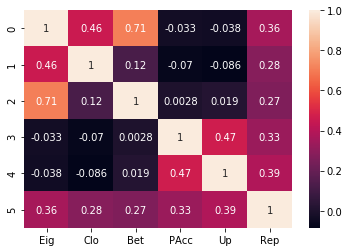

In [19]:
import re
import csv
import sys
import random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns
%matplotlib inline

def main():
    
    # import tables for Java, python and R
    rUsers= pd.read_csv("r_users.csv")
    pythonUsers= pd.read_csv("python_users.csv")
    javaUsers=pd.read_csv("java_users.csv") 
    
    javaQuestions = pd.read_csv("java_questions.csv",sep=";",error_bad_lines=False)
    pythonQuestions= pd.read_csv("python_questions.csv",error_bad_lines=False)
    rQuestions= pd.read_csv("r_questions.csv")
    
    javaAnswers = pd.read_csv("java_answers.csv",error_bad_lines=False)
    pythonAnswers = pd.read_csv("python_answers.csv",error_bad_lines=False) 
    rAnswers= pd.read_csv("r_answers.csv")
    
    # read Barbara's metric
    rProbAcc=pd.read_csv("barbarametric.csv") 
    rProbAcc = rProbAcc.sort_values([' CreationDate'])
    
    # read Nirmal's metric betweeness
    rBetween = pd.read_csv("lil_between.csv")
    rBetween = formatCreationDateColumn1(rBetween)
    rBetween = rBetween.sort_values(['CreationDate','UserId'])
    
    # read Nirmal's metric 2 closeness
    rClose = pd.read_csv("lil_close.csv") 
    rClose = formatCreationDateColumn1(rClose)
    rClose = rClose.sort_values(['CreationDate', 'UserId'])
    
    # read Nirmal's metric 3 eigen 
    rEig = pd.read_csv("lil_eig.csv") 
    rEig = formatCreationDateColumn1(rEig)
    rEig = rEig.sort_values(['CreationDate','UserId']) 
    
    
   
    # UpMetric creation for every language
    rAnswers = upMetricCreation(rAnswers)
    pythonAnswers = upMetricCreation(pythonAnswers)
    javaAnswers = upMetricCreation(javaAnswers)
    
    
    # format data column for all the tables
    rAnswers = formatCreationDateColumn(rAnswers)
    javaAnswers = formatCreationDateColumn(javaAnswers)
    pythonAnswers = formatCreationDateColumn(pythonAnswers)
    
    rAnswers = rAnswers.sort_values(' OwnerUserId')
    
    rQuestions = formatCreationDateColumn(rQuestions)
    javaQuestions = formatCreationDateColumn(javaQuestions)
    pythonQuestions = formatCreationDateColumn(pythonQuestions)
    
    
    # get first activity per user in all the languages
    rFirstActTable = gettingTableUserFirstActivity(rAnswers,rQuestions)
    javaFirstActTable = gettingTableUserFirstActivity(javaAnswers,javaQuestions)
    pythonFirstActTable = gettingTableUserFirstActivity(pythonAnswers,pythonQuestions)
    
    
    # obtainSummaryUpMetric per language
    rSummaryUpMetricAnswer = obtainSummaryUpMetric(rAnswers,rQuestions,rFirstActTable)
    rSummaryUpMetricAnswer = rSummaryUpMetricAnswer.sort_values([' CreationDate'])
    javaSummaryUpMetricAnswer = obtainSummaryUpMetric(javaAnswers,javaQuestions,javaFirstActTable)
    javaSummaryUpMetricAnswer = javaSummaryUpMetricAnswer.sort_values([' CreationDate'])
    pythonSummaryUpMetricAnswer = obtainSummaryUpMetric(pythonAnswers,pythonQuestions,pythonFirstActTable)
    pythonSummaryUpMetricAnswer = pythonSummaryUpMetricAnswer.sort_values([' CreationDate'])
    
    # take away users with few answers
    rSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(rAnswers,rSummaryUpMetricAnswer)
    javaSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(javaAnswers,javaSummaryUpMetricAnswer)
    pythonSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(pythonAnswers, pythonSummaryUpMetricAnswer)
    
    
    rSummaryUpMetricAnswerFew = addZeroTimepoint(rSummaryUpMetricAnswerFew)
    javaSummaryUpMetricAnswerFew = addZeroTimepoint(javaSummaryUpMetricAnswerFew)
    pythonSummaryUpMetricAnswerFew = addZeroTimepoint(pythonSummaryUpMetricAnswerFew)
    
    
    ######## plots ###
    #plotEvolutionRandomUsers(rSummaryUpMetricAnswer,"R")
    #plotEvolutionRandomUsers(javaSummaryUpMetricAnswer,"JAVA")
    #plotEvolutionRandomUsers(pythonSummaryUpMetricAnswer,"Python")
    
    #aggregateIndividualLearningCurves(rSummaryUpMetricAnswer,0,100,"R")
    #
    #
    
    
    ### Correlation between ProbAcc and UpMetric
    rSummaryUpMetricAnswer['OnlyDate'] = pd.to_datetime(rSummaryUpMetricAnswer[' CreationDate'],errors="coerce")
    rSummaryUpMetricAnswer['OnlyDate'] = rSummaryUpMetricAnswer['OnlyDate'].dt.date
    rSummaryUpMetricAnswer= rSummaryUpMetricAnswer.sort_values(['OnlyDate'])

    
    rPerWeekUpMetric =aggregatePerWeek(rSummaryUpMetricAnswer)
    rPerWeekUpMetric = filterUsers(rPerWeekUpMetric)
    
    rSummaryProbAccAnswer = rProbAcc
    rSummaryProbAccAnswer['OnlyDate'] = pd.to_datetime(rProbAcc[' CreationDate'],errors="coerce")
    rSummaryProbAccAnswer['OnlyDate'] = rSummaryProbAccAnswer['OnlyDate'].dt.date
    rSummaryProbAccAnswer= rSummaryProbAccAnswer.sort_values(['OnlyDate'])
    rPerWeekProbAcc = aggregatePerWeek(rProbAcc)
    rPerWeekProbAcc = filterUsers(rPerWeekProbAcc)
    
    ######### 
    
    rBetween = rBetween.sort_values(['CreationDate','UserId'])
    rClose = rClose.sort_values(['CreationDate','UserId'])
    rEig = rEig.sort_values(['CreationDate','UserId'])
    rPerWeekProbAcc = rPerWeekProbAcc.sort_values(['Week',' OwnerUserId'])
    print('Correlation between ProbAcc and Betweenness')
    rCorrProbBet = rPerWeekProbAcc['ProbAccAnswer'].corr(rBetween['Betweenness'], method='spearman')
    print(rCorrProbBet)
    
    print('Correlation between ProbAcc and Closeness')
    rCorrProbClo = rPerWeekProbAcc['ProbAccAnswer'].corr(rClose['Closness'], method='spearman')
    print(rCorrProbClo)
    
    print('Correlation between ProbAcc and Eigen')
    rCorrProbEig = rPerWeekProbAcc['ProbAccAnswer'].corr(rEig['EigenCen'], method='spearman')
    print(rCorrProbEig)

    ####### 
    rPerWeekUpMetric = rPerWeekUpMetric.sort_values('Week')
    print('Correlation between UpMetric and Betweenness')
    rCorrUpBet = rPerWeekUpMetric['UpMetric'].corr(rBetween['Betweenness'], method='spearman')
    print(rCorrUpBet)
    
    print('Correlation between UpMetric and Closeness')
    rCorrUpClo = rPerWeekUpMetric['UpMetric'].corr(rClose['Closness'], method='spearman')
    print(rCorrUpClo)
    
    print('Correlation between UpMetric and Eigen')
    rCorrUpEig = rPerWeekUpMetric['UpMetric'].corr(rEig['EigenCen'], method='spearman')
    print(rCorrUpEig)
    
    ### WRONG
    #rPerWeekUpMetric = rPerWeekUpMetric.sort_values([' CreationDate',' OwnerUserId'])
    #rPerWeekProbAcc = rPerWeekProbAcc.sort_values([' CreationDate',' OwnerUserId']) 
    #rCorrUpProb = rPerWeekUpMetric['UpMetric'].corr(rPerWeekProbAcc['ProbAccAnswer'],method='spearman')
    #print('Correlation between UpMetric and ProbAcc')
    #print(rCorrUpProb)
    

    ########### R Language ###########
    ## COMPARISON BETWEEN ProbAcc and UpMetric
    rPerWeekProbAcc = rPerWeekProbAcc.sort_values(['Week']) 
    #rEig = rEig.sort_values('CreationDate')
    #rClose = rClose.sort_values('CreationDate')
    #rBetween = rBetween.sort_values('CreationDate')
    upMetricVSprobAcc = pd.DataFrame()
    rSummaryProbAccAnswer = rSummaryProbAccAnswer.sort_values([' CreationDate',' OwnerUserId'])
    rSummaryUpMetricAnswer = rSummaryUpMetricAnswer.sort_values([' CreationDate',' OwnerUserId'])
    upMetricVSprobAcc['ProbAcc'] = rSummaryProbAccAnswer['ProbAccAnswer']
    upMetricVSprobAcc['UpMetric'] = rSummaryUpMetricAnswer['UpMetric']
    
    rCorrUpProb = upMetricVSprobAcc['ProbAcc'].corr(upMetricVSprobAcc['UpMetric'])
    print('Correlation between UpMetric and ProbAcc')
    print(rCorrUpProb)
    
    ##### COMPARISON WITH Reputation ####
    # get most recent UpMetric (per Week) score per user
    print('Correlation between UpMetric and Reputation')
    lastUpMetricPerUserWithRep = getLastUpMetricPerUser(rPerWeekUpMetric,rUsers)
    # Compares UpMetric with Reputation Score
    rCorrUpMetricRep = lastUpMetricPerUserWithRep['UpMetric'].corr(lastUpMetricPerUserWithRep['Reputation'],method='spearman')
    print(rCorrUpMetricRep)
    # get most recent Prob score per user and relates ProbAcc with Reputation
    print('Correlation between ProbAcc and Reputation')
    lastProbAccPerUserWithRep = getLastProbAccPerUser(rProbAcc,rUsers)
    rCorrProbAccRep = lastProbAccPerUserWithRep['ProbAccAnswer'].corr(lastProbAccPerUserWithRep['Reputation'],method='spearman')
    print(rCorrProbAccRep)
    
    # corr between network features
    print('Correlation between Betweenness and Eigen Centrality')
    rCorrEigBet = rEig['EigenCen'].corr(rBetween['Betweenness'],method='spearman')
    print(rCorrEigBet)
    print('Correlation between Closeness and Eigen Centrality')
    rCorrEigClo = rEig['EigenCen'].corr(rClose['Closness'],method='spearman')
    print(rCorrEigClo)
    print('Correlation between Betweenness and Closeness')
    rCorrBetClo = rBetween['Betweenness'].corr(rClose['Closness'],method='spearman')
    print(rCorrBetClo)
    
    # Compares Eigen Centrality with Reputation Score
    print('Correlation between Eigen and Reputation')
    lastEigPerUserWithRep = getLastEigPerUser(rEig,rUsers)
    rCorrEigRep = lastEigPerUserWithRep['EigenCen'].corr(lastEigPerUserWithRep['Reputation'],method='spearman')
    print(rCorrEigRep)
    
    # Compares Betweenness with Reputation Score
    print('Correlation between Betweeness and Reputation')
    lastBetPerUserWithRep = getLastBetPerUser(rBetween,rUsers)
    rCorrBetRep = lastBetPerUserWithRep['Betweenness'].corr(lastBetPerUserWithRep['Reputation'],method='spearman')
    print(rCorrBetRep)
    
    print('Correlation between Closeness and Reputation')
    lastCloPerUserWithRep = getLastCloPerUser(rClose,rUsers)
    rCorrCloRep = lastCloPerUserWithRep['Closness'].corr(lastCloPerUserWithRep['Reputation'],method='spearman')
    print(rCorrCloRep)
    
    rCorrTable = pd.DataFrame()
    
    #rCorrTable['row'] = ['Eig', 'Clo', 'Bet', 'PAcc','Up','Rep']
    rCorrTable['Eig'] = [1,rCorrEigClo,rCorrEigBet,rCorrProbEig,rCorrUpEig,rCorrEigRep]
    rCorrTable['Clo'] = [rCorrEigClo,1,rCorrBetClo,rCorrProbClo,rCorrUpClo,rCorrCloRep]
    rCorrTable['Bet'] = [rCorrEigBet,rCorrBetClo,1,rCorrProbBet,rCorrUpBet,rCorrBetRep]
    rCorrTable['PAcc']= [rCorrProbEig,rCorrProbClo,rCorrProbBet,1,rCorrUpProb,rCorrProbAccRep]
    rCorrTable['Up']  = [rCorrUpEig,rCorrUpClo,rCorrUpBet,rCorrUpProb,1,rCorrUpMetricRep]
    rCorrTable['Rep'] = [rCorrEigRep,rCorrCloRep,rCorrBetRep,rCorrProbAccRep,rCorrUpMetricRep,1]
    #rCorrTable.set_index('row')
    
    sns.heatmap(rCorrTable, annot=True)
    return()

def getLastEigPerUser(table,usersTable):
   
    table = table.sort_values('CreationDate').drop_duplicates(subset=['UserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values('UserId')
    answersWithScore = table.merge(usersTable, left_on='UserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['CreationDate', 'UserId','EigenCen','Reputation'])
    table = table.sort_values('UserId')
    return table

def getLastCloPerUser(table,usersTable):
 
    table = table.sort_values('CreationDate').drop_duplicates(subset=['UserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values('UserId')
    answersWithScore = table.merge(usersTable, left_on='UserId', right_on='Id', how='inner')
   # table = answersWithScore.filter(items=['CreationDate', 'UserId','Closenss','Reputation'])
    table= answersWithScore
    table = table.sort_values('UserId')
    
    return table

def getLastBetPerUser(table,usersTable):

    table = table.sort_values('CreationDate').drop_duplicates(subset=['UserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values('UserId')
    answersWithScore = table.merge(usersTable, left_on='UserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['CreationDate', 'UserId','Betweenness','Reputation'])
    table = table.sort_values('UserId')
    return table

def getLastUpMetricPerUser(table,usersTable):
    table = table.sort_values('OnlyDate').drop_duplicates(subset=[' OwnerUserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values(' OwnerUserId')
    answersWithScore = table.merge(usersTable, left_on=' OwnerUserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['OnlyDate','Week', ' OwnerUserId','UpMetric','Reputation'])
    table = table.sort_values(' OwnerUserId')
    return table

def getLastProbAccPerUser(table,usersTable):
    table = table.sort_values('OnlyDate').drop_duplicates(subset=[' OwnerUserId'], keep='last')
    usersTable = usersTable.sort_values('Id')
    table = table.sort_values(' OwnerUserId')
    answersWithScore = table.merge(usersTable, left_on=' OwnerUserId', right_on='Id', how='inner')
    table = answersWithScore.filter(items=['OnlyDate','Week', ' OwnerUserId','ProbAccAnswer','Reputation'])
    table = table.sort_values(' OwnerUserId')
    return table

def filterUsers(perWeekTable):
    perWeekTable = perWeekTable.sort_values('OnlyDate').drop_duplicates(subset=['Week', ' OwnerUserId'], keep='last')
    return perWeekTable

def aggregatePerWeek(summaryTable):
    summaryTable = summaryTable.sort_values(['OnlyDate'])
    uniqueTime = summaryTable['OnlyDate'].unique()

    uniqueTime = pd.DataFrame(uniqueTime)
    uniqueTime= uniqueTime.reset_index()
    uniqueTime= uniqueTime[1:]
    uniqueTime.columns= ['Index','OnlyDate']
    
    uniqueTime.insert(1, 'Day', range(0, 0 + len(uniqueTime)))

    uniqueTime['Week'] = np.where((uniqueTime['Day']%7)==0 , uniqueTime['Day']//7 ,uniqueTime['Day']//7)
    
#    print (uniqueTime)
    #summaryTable=summaryTable.sort_values(['OnlyDate',' OwnerUserId'])
    summaryTable= summaryTable.merge(uniqueTime, left_on='OnlyDate', right_on='OnlyDate', how='inner')

    #perWeekMetric= summaryTable.filter(items=['OnlyDate','Week', ' OwnerUserId','UpMetric'])

    
    return(summaryTable)
    
# function upMetricCreation    
# parameter : table
# returns : table with extra columns
# Summary : Adds a new metric that is based on the CumScore achieved so far by the user dividid
# by the number of answers answered until a certain point in time
# Step-by-step:
# considers the absolute total score within a question
# add the score per question as a column in the answersTable by merging
# considers a relative score that each user has within a question
# the number of cumulative questions (per user) answered so far is added as a column
# the order per user and creation date has to be maintained in order to make a cumulative score through the questions
# the UpMetric is calculated based on : cumScore/cumSumQuestions in a certain point in time 
# this value/metric changes every time a user answers a question
def upMetricCreation(table):
    answersTable = pd.read_table("r_answers.csv", sep=",") 
    
    answersTable[' AbsSum']= answersTable[' Score'].abs()

    # the absolute total score by question
    questiondf = answersTable.groupby([' ParentId'])[' AbsSum'].sum()
    
    questiondf = pd.DataFrame(questiondf)
    questiondf= questiondf.reset_index()
                
    #merge the table of answers and question
    answersTable= answersTable.merge(questiondf,left_on=' ParentId',suffixes=('', 'Global'), right_on=' ParentId', how='left')
    answersTable   
    
    # Score relative to the question, multiplied by the signal of the "individual" score
    answersTable[' RelativeScore'] =  answersTable[' AbsSum'] / answersTable[' AbsSumGlobal']  
    
    answersTable.loc[answersTable[' Score'] < 0,' RelativeScore'] = - answersTable[' RelativeScore'] 
    answersTable.loc[answersTable[' Score'] == 0,' RelativeScore'] =0
    
    # The cum. number of questions answers by user 
    answersTable['CumSumQuestions'] = answersTable.groupby(' OwnerUserId').cumcount() + 1
    
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user
    
    answersTable['CumScore'] = answersTable.groupby(' OwnerUserId')[' RelativeScore'].cumsum()
    
    
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user
    
    

    answersTable['UpMetric'] = answersTable['CumScore']/answersTable['CumSumQuestions'] 
    return(answersTable)

# function formatCreationDateColumn    
# parameter : table
# returns : table 
# Summary : Converts the creationDate field into a datetime format
def formatCreationDateColumn(table_provided):
    table = table_provided.copy()
    #Correcting format of dates in the table
    table[' CreationDate']=pd.to_datetime(table[' CreationDate'],errors="coerce")
    
    #remove lines which could not be formatted to correct date format
    table=table.loc[~table[" CreationDate"].isnull()]
    
    return(table)

def formatCreationDateColumn1(table_provided):
    table = table_provided.copy()
    #Correcting format of dates in the table
    table['CreationDate']=pd.to_datetime(table['CreationDate'],errors="coerce")
    
    #remove lines which could not be formatted to correct date format
    table=table.loc[~table["CreationDate"].isnull()]
    
    return(table)
# function gettingTableUserFirstActivity
# parameter : answersTable, questionsTable
# returns : firstActivityTable  
# Summary : I looks for the first question date and first answer date, chooses the minimum and puts 
# it on the firstActivityTable (per user)
def gettingTableUserFirstActivity(answersTable_provided,questionsTable_provided):
    answersTable = answersTable_provided.copy()
    questionsTable = questionsTable_provided.copy()
   
    #identify the first activity of users
    answersTable["FirstActivity"]=~answersTable[" OwnerUserId"].duplicated()
    questionsTable["FirstActivity"]=~questionsTable[" OwnerUserId"].duplicated()
    
    #obtaining first answer and first question of a user
    firstAnswers=answersTable.loc[answersTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]

    firstQuestions = questionsTable.loc[questionsTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
  
    #and merge them into one table
    firstActTable=firstQuestions.merge(firstAnswers, left_on=" OwnerUserId", right_on=" OwnerUserId", how='outer')
    firstActTable.columns = [" OwnerUserId","FirstQuestion","FirstAnswer"]
    
    #obtain first activity (either answer or question)
    firstActTable["FirstActivity"]=firstActTable[["FirstQuestion","FirstAnswer"]].min(axis=1)
    
    
    return(firstActTable)

# function obtainSummaryUpMetric
# parameter : answersTable, questionsTable, FirstActivityTable
# returns : summaryTable  
# Summary : It normalizes the time by Merging the answersTable with the FirstActTable, defines a new column 
# "Present" as the most recent Answer date calculates the difference between the creation of the answers and 
# the date of the first activity of the usercalculates the differente between the last answer of the user
# and he's first activity date both measured in days and then the days are normalized
def obtainSummaryUpMetric(answersTable,questionsTable,firstActTable):
    
    #Adding first activity table to answerstable 
    summaryTableAnswer = answersTable[["Id"," OwnerUserId"," CreationDate"," ParentId","UpMetric"]]
    summaryTableAnswer=summaryTableAnswer.merge(firstActTable,left_on = " OwnerUserId",right_on=" OwnerUserId")
    
    #Use first activity to obtain normalized time
    summaryTableAnswer["Present"]= max(summaryTableAnswer[" CreationDate"])
    
    #timestamp of answer compared to first activity of that user
    summaryTableAnswer["DifferenceNumerator"]=(summaryTableAnswer[" CreationDate"]-summaryTableAnswer["FirstActivity"])
    summaryTableAnswer["DifferenceDenominator"]=(summaryTableAnswer["Present"]-summaryTableAnswer["FirstActivity"])
    
    summaryTableAnswer.DifferenceNumerator=summaryTableAnswer.DifferenceNumerator.dt.total_seconds() /(24*3600) # to obtain days with decimals
    summaryTableAnswer.DifferenceDenominator=summaryTableAnswer.DifferenceDenominator.dt.total_seconds()/(24*3600)
    summaryTableAnswer["NormTime"]=summaryTableAnswer["DifferenceNumerator"]/summaryTableAnswer["DifferenceDenominator"]
    
    return(summaryTableAnswer)

## Task3 Remove users with less than 5 answers
def removeUsersWithFewAnswers(answersTable,summaryTableAnswer):
    nrQuestionsperUser = answersTable[" OwnerUserId"].value_counts()
    lessthan5users=nrQuestionsperUser[nrQuestionsperUser<5].index
    nrUsersBefore=len(list(set(summaryTableAnswer[" OwnerUserId"].tolist())))
    filteredTable=summaryTableAnswer.loc[~summaryTableAnswer[" OwnerUserId"].isin(lessthan5users)]
    nrUsersAfter=len(list(set(filteredTable[" OwnerUserId"].tolist())))
    print(1-nrUsersAfter/nrUsersBefore,"% of the users were removed.")
    return(filteredTable)

## Task4 Prolong data until 0 timepoint, for the cases in which first activity is a question
def addZeroTimepoint(summaryTableAnswer_provided):
    summaryTableAnswer=summaryTableAnswer_provided.copy()
    #Add 0 to time 0
    usersWhoHaveZero=list(set(summaryTableAnswer[" OwnerUserId"][summaryTableAnswer["NormTime"]==0].tolist()))
    usersArtificialZero = list(set(summaryTableAnswer[" OwnerUserId"][~summaryTableAnswer[" OwnerUserId"].isin(usersWhoHaveZero)].tolist()))
    tempdfArtificialZero = pd.DataFrame(0, index=np.arange(len(usersArtificialZero)), columns=list(summaryTableAnswer.columns.values))
    tempdfArtificialZero[" OwnerUserId"]=usersArtificialZero
    tempdfArtificialZero[" OwnerUserId"]=tempdfArtificialZero[" OwnerUserId"].astype(np.int64) # make type correct
    summaryTableAnswer = summaryTableAnswer.append(tempdfArtificialZero, ignore_index=True)

    #reorder again
    summaryTableAnswer=summaryTableAnswer.sort_values([' OwnerUserId','NormTime']) #order by user
    return(summaryTableAnswer)

def plotEvolutionRandomUsers(summaryTableAnswer,language):
    r_users=summaryTableAnswer.loc[np.random.choice(summaryTableAnswer.index, 6)][" OwnerUserId"].tolist()
    plt.figure(figsize=(12,8))

    for i in range(0,6):
        user=r_users[i]
        plt.subplot(3,2,i+1)
        plt.xlabel("Days since first activity in "+language)
        plt.ylabel("Ratio of Up Votes within a Question")
        plt.plot(summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["DifferenceNumerator"].tolist(),summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["UpMetric"].tolist())
    
    plt.tight_layout()
    plt.show()
    
    
def aggregateIndividualLearningCurves(summaryTableAnswer,thresExpertise,threshUsers,language):
    #possible timepoints from 0 to the maximum span.
    x_all = np.linspace(0, max(summaryTableAnswer["DifferenceDenominator"]),num=5000, endpoint=True)
    
    #variable initialization
    sumProbs = np.zeros(len(x_all))
    nrUsers = np.zeros(len(x_all))
    users = list(set(summaryTableAnswer[" OwnerUserId"].tolist()))

    consUsers=0 #considered users

    #for each user:
    #linear interpolation - already checked that curve shape is similar to the ones obtained individually
    for user in users:
        xs_user=summaryTableAnswer["DifferenceNumerator"][summaryTableAnswer[" OwnerUserId"]==user].tolist()
        probs_user= summaryTableAnswer["UpMetric"][summaryTableAnswer[" OwnerUserId"]==user].tolist()
        
        #interpolation function for this user
        f1 = interp1d(xs_user,probs_user ,'linear')
        
        # only interpolated values are considered, meaning no extrapolated values
        subset_x_all=x_all[x_all<max(xs_user)]
        f1_int = f1(subset_x_all)
    
        
        # only users that are considered to achieve expertise will be taken into consideration for computing the learning curve
        if (min(probs_user[-5:])>thresExpertise):
            consUsers=consUsers+1
       
            #update probability sums at each time point with the interpolated probabilities for this user
            sumProbs[0:len(subset_x_all)]=sumProbs[0:len(subset_x_all)]+f1_int
            #update nr users 
            nrUsers[0:len(subset_x_all)] = nrUsers[0:len(subset_x_all)]+1

    
    #Remove timepoints which have less than a threshold number of users
    noUsersPos = np.where(nrUsers>threshUsers)
    sumProbs=sumProbs[noUsersPos]
    nrUsers=nrUsers[noUsersPos]
    x_all=x_all[noUsersPos]
    
    probs=sumProbs/nrUsers
    
    print((len(users)-consUsers)/len(users), " were not considered")
    print (consUsers, " were considered in total")
    plt.figure()
    plt.xlabel("Days since first activity in " + language)
    plt.ylabel("Probability of answer\ngetting accepted")
    plt.plot(x_all, probs)
    plt.show()
main()


In [6]:
#answersTable.loc[answersTable[' Score'] < 0,' RelativeScore'] = - answersTable[' RelativeScore'] 
    
#answersTable.loc[answersTable[' Score'] == 0,' RelativeScore'] =0

#COPIED

In [8]:
#answersTable['CumSumQuestions'] = answersTable.groupby(' OwnerUserId').cumcount() + 1
#COPIED

In [11]:
#answersTable['CumScore'] = answersTable[' RelativeScore'] / answersTable['CumSumQuestions']
#copied

In [14]:
answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user

In [15]:
#answersTable['CumScore'] = answersTable.groupby(' OwnerUserId')[' RelativeScore'].cumsum()

#COPIED

In [66]:
#answersTable['UpMetric'] = answersTable['CumScore']/answersTable['CumSumQuestions'] 
#answersTable

#COPIED

In [18]:
## plotting
import matplotlib.pyplot as plt
answersTable.loc[answersTable[ "CumSumQuestions"].idxmax()]
user = 3732271 


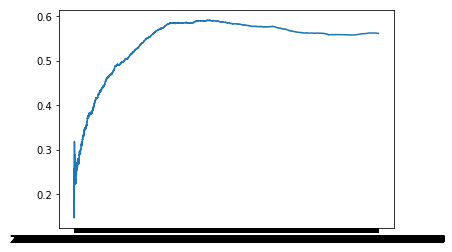

In [19]:
plt.figure()
plt.plot(answersTable.loc[answersTable[" OwnerUserId"]==user][" CreationDate"].tolist(),answersTable.loc[answersTable[" OwnerUserId"]==user]["UpMetric"].tolist())
plt.show()

In [27]:
#Normalization: 0 should correspond to time of first activity and 1 to present date. 
#1 converting creation date to proper time format

questionsTable = pd.read_table("r_questions.csv", sep=",")
questionsTable=questionsTable.sort_values([' OwnerUserId',' CreationDate'])

answersTable[' CreationDate']=pd.to_datetime(answersTable[' CreationDate'])
questionsTable[' CreationDate']=pd.to_datetime(questionsTable[' CreationDate'])



/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
questionsTable

,Id,OwnerUserId,CreationDate,LastActivityDate,Score,AcceptedAnswerId,AnswerCount,CommentCount,ViewCount,FavoriteCount,Unnamed: 10
1,79709,0,2008-09-17 03:39:16.913,2016-04-28T13:21:33.607,5,0,7,2,830,3,NaN
3,102056,0,2008-09-19 14:03:25.997,2014-07-10T18:16:29.313,121,0,21,2,11060,53,NaN
4,103312,0,2008-09-19 16:09:26.053,2015-04-23T05:16:26.967,5,0,2,0,3402,0,NaN
28,713878,0,2009-04-03 13:23:03.610,2014-06-11T06:55:38.080,27,0,7,2,23014,12,NaN
60,1166157,0,2009-07-22 15:36:30.007,2009-07-22T16:16:31.767,0,0,1,1,980,1,NaN
64,1169292,0,2009-07-23 02:35:28.683,2009-07-23T05:01:34.753,8,0,3,0,3132,2,NaN
108,1262911,0,2009-08-11 21:04:53.483,2015-12-17T05:52:23.427,2,0,2,1,439,1,NaN
134,1343442,0,2009-08-27 19:55:04.677,2016-02-16T11:40:47.727,8,0,5,0,1196,2,NaN
160,1395118,0,2009-09-08 17:07:55.250,2016-03-04T10:37:55.173,1,0,1,0,304,0,NaN
168,1395189,0,2009-09-08 17:21:50.620,2016-03-04T10:29:37.517,6,0,3,0,957,1,NaN


In [81]:
#2 create relativeTime
#2.1 identify the first activity of users
answersTable["FirstActivity"]=~answersTable[" OwnerUserId"].duplicated()
questionsTable["FirstActivity"]=~questionsTable[" OwnerUserId"].duplicated()

firstAnswers=answersTable.loc[answersTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
firstQuestions = questionsTable.loc[questionsTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]

In [82]:
questionsTable

,Id,OwnerUserId,CreationDate,LastActivityDate,Score,AcceptedAnswerId,AnswerCount,CommentCount,ViewCount,FavoriteCount,Unnamed: 10,FirstActivity
1,79709,0,2008-09-17 03:39:16.913,2016-04-28T13:21:33.607,5,0,7,2,830,3,NaN,True
3,102056,0,2008-09-19 14:03:25.997,2014-07-10T18:16:29.313,121,0,21,2,11060,53,NaN,False
4,103312,0,2008-09-19 16:09:26.053,2015-04-23T05:16:26.967,5,0,2,0,3402,0,NaN,False
28,713878,0,2009-04-03 13:23:03.610,2014-06-11T06:55:38.080,27,0,7,2,23014,12,NaN,False
60,1166157,0,2009-07-22 15:36:30.007,2009-07-22T16:16:31.767,0,0,1,1,980,1,NaN,False
64,1169292,0,2009-07-23 02:35:28.683,2009-07-23T05:01:34.753,8,0,3,0,3132,2,NaN,False
108,1262911,0,2009-08-11 21:04:53.483,2015-12-17T05:52:23.427,2,0,2,1,439,1,NaN,False
134,1343442,0,2009-08-27 19:55:04.677,2016-02-16T11:40:47.727,8,0,5,0,1196,2,NaN,False
160,1395118,0,2009-09-08 17:07:55.250,2016-03-04T10:37:55.173,1,0,1,0,304,0,NaN,False
168,1395189,0,2009-09-08 17:21:50.620,2016-03-04T10:29:37.517,6,0,3,0,957,1,NaN,False


In [83]:
firstActTable=firstQuestions.merge(firstAnswers, left_on=" OwnerUserId", right_on=" OwnerUserId", how='outer')
firstActTable.columns = [" OwnerUserId","FirstQuestion","FirstAnswer"]

In [78]:
firstActTable["FirstActivity"]=firstActTable[["FirstQuestion","FirstAnswer"]].min(axis=1)

In [79]:
firstActTable #confirmed that is correct for userId 277 and 280

,OwnerUserId,FirstQuestion,FirstAnswer,FirstActivity
0,0,2008-09-17 03:39:16.913,2008-09-17T03:51:30.190,NaN
1,277,2008-09-24 13:31:07.500,2011-01-18T17:53:30.627,NaN
2,280,2009-12-11 01:18:47.903,NaN,NaN
3,337,2014-10-16 17:33:39.987,2014-08-19T19:58:00.707,NaN
4,357,2016-03-04 15:00:16.023,NaN,NaN
5,404,2010-01-23 00:30:05.610,NaN,NaN
6,422,2009-05-18 08:16:10.573,NaN,NaN
7,445,2009-01-31 14:50:28.677,2009-02-04T15:12:59.503,NaN
8,572,2009-01-07 13:27:28.407,NaN,NaN
9,681,2012-04-06 21:21:34.377,2012-10-01T22:57:01.570,NaN


In [41]:
#Adding first activity table to answerstable 
summaryTableAnswer = answersTable[["Id"," OwnerUserId"," CreationDate"," ParentId","UpMetric"]]
summaryTableAnswer=summaryTableAnswer.merge(firstActTable,left_on = " OwnerUserId",right_on=" OwnerUserId")

In [42]:
#Use first activity to obtain normalized time
summaryTableAnswer["Present"]= max(summaryTableProbAccAnswer[" CreationDate"])
summaryTableAnswer["DifferenceNumerator"]=(summaryTableAnswer[" CreationDate"]-summaryTableAnswer["FirstActivity"])
summaryTableAnswer["DifferenceDenominator"]=(summaryTableAnswer["Present"]-summaryTableAnswer["FirstActivity"])

In [43]:
summaryTableAnswer.DifferenceNumerator=summaryTableAnswer.DifferenceNumerator.dt.total_seconds() /(24*3600)
summaryTableAnswer.DifferenceDenominator=summaryTableAnswer.DifferenceDenominator.dt.total_seconds()/(24*3600)
summaryTableAnswer["NormTime"]=summaryTableAnswer["DifferenceNumerator"]/summaryTableAnswer["DifferenceDenominator"]

In [44]:
summaryTableAnswer

,Id,OwnerUserId,CreationDate,ParentId,UpMetric,FirstQuestion,FirstAnswer,FirstActivity,Present,DifferenceNumerator,DifferenceDenominator,NormTime
0,79788,0,2008-09-17 03:51:30.190,79709,0.173913,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,0.008487,3462.026488,0.000002
1,86804,0,2008-09-17 19:39:37.370,79709,0.108696,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,0.666903,3462.026488,0.000193
2,476928,0,2009-01-25 00:05:19.107,476726,0.298654,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,129.851414,3462.026488,0.037507
3,501926,0,2009-02-02 00:42:27.250,501917,0.312226,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,137.877203,3462.026488,0.039826
4,612573,0,2009-03-04 21:41:41.980,596819,0.329781,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,168.751679,3462.026488,0.048744
5,750852,0,2009-04-15 08:58:03.103,750786,0.273813,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,210.221368,3462.026488,0.060722
6,823251,0,2009-05-05 03:50:25.733,750786,0.241582,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,230.007741,3462.026488,0.066437
7,876778,0,2009-05-18 08:56:02.270,876711,0.220643,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,243.219969,3462.026488,0.070254
8,969680,0,2009-06-09 12:03:40.747,750786,0.272433,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,265.350276,3462.026488,0.076646
9,1116218,0,2009-07-12 15:18:02.497,1114699,0.264237,2008-09-17 03:39:16.913,2008-09-17 03:51:30.190,2008-09-17 03:39:16.913,2018-03-11 04:17:25.483,298.485250,3462.026488,0.086217


In [45]:
#Remove users who have less than 5 answers
nrQuestionsperUser = answersTable[" OwnerUserId"].value_counts()

lessthan5users=nrQuestionsperUser[nrQuestionsperUser<5].index
nrUsersBefore=len(list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist())))
summaryTableProbAccAnswer=summaryTableProbAccAnswer.loc[~summaryTableProbAccAnswer[" OwnerUserId"].isin(lessthan5users)]
nrUsersAfter=len(list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist())))
print(1-nrUsersAfter/nrUsersBefore,"% of the users were removed.")

0.8437442133201654 % of the users were removed.


In [46]:
#Add 0 to time 0 and prolong score to 1
usersWhoHaveZero=list(set(summaryTableProbAccAnswer[" OwnerUserId"][summaryTableProbAccAnswer["NormTime"]==0].tolist())) # around 3000
usersArtificialZero = list(set(summaryTableProbAccAnswer[" OwnerUserId"][~summaryTableProbAccAnswer[" OwnerUserId"].isin(usersWhoHaveZero)].tolist()))
tempdfArtificialZero = pd.DataFrame(0, index=np.arange(len(usersArtificialZero)), columns=list(summaryTableProbAccAnswer.columns.values))
tempdfArtificialZero[" OwnerUserId"]=usersArtificialZero
tempdfArtificialZero[" OwnerUserId"]=tempdfArtificialZero[" OwnerUserId"].astype(np.int64)
summaryTableProbAccAnswer = summaryTableProbAccAnswer.append(tempdfArtificialZero, ignore_index=True)

#reorder again
summaryTableProbAccAnswer=summaryTableProbAccAnswer.sort_values([' OwnerUserId','NormTime']) #order by user
summaryTableProbAccAnswer

,Id,OwnerUserId,CreationDate,ParentId,UpMetric,FirstQuestion,FirstAnswer,FirstActivity,Present,DifferenceNumerator,DifferenceDenominator,NormTime
252282,0,0,0,0,0.000000,0,0,0,0,0.000000,0.000000,0.000000
0,79788,0,2008-09-17 03:51:30.190000,79709,0.173913,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,0.008487,3462.026488,0.000002
1,86804,0,2008-09-17 19:39:37.370000,79709,0.108696,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,0.666903,3462.026488,0.000193
2,476928,0,2009-01-25 00:05:19.107000,476726,0.298654,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,129.851414,3462.026488,0.037507
3,501926,0,2009-02-02 00:42:27.250000,501917,0.312226,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,137.877203,3462.026488,0.039826
4,612573,0,2009-03-04 21:41:41.980000,596819,0.329781,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,168.751679,3462.026488,0.048744
5,750852,0,2009-04-15 08:58:03.103000,750786,0.273813,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,210.221368,3462.026488,0.060722
6,823251,0,2009-05-05 03:50:25.733000,750786,0.241582,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,230.007741,3462.026488,0.066437
7,876778,0,2009-05-18 08:56:02.270000,876711,0.220643,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,243.219969,3462.026488,0.070254
8,969680,0,2009-06-09 12:03:40.747000,750786,0.272433,2008-09-17 03:39:16.913000,2008-09-17 03:51:30.190000,2008-09-17 03:39:16.913000,2018-03-11 04:17:25.483000,265.350276,3462.026488,0.076646


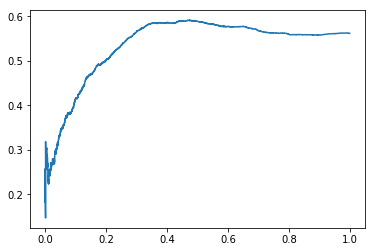

In [48]:
#Example - shape should be the same but with different x axis, between 0 and 1
user = 3732271
plt.figure()
plt.plot(summaryTableProbAccAnswer.loc[summaryTableProbAccAnswer[" OwnerUserId"]==user]["NormTime"].tolist(),summaryTableProbAccAnswer.loc[summaryTableProbAccAnswer[" OwnerUserId"]==user]["UpMetric"].tolist())
plt.show()

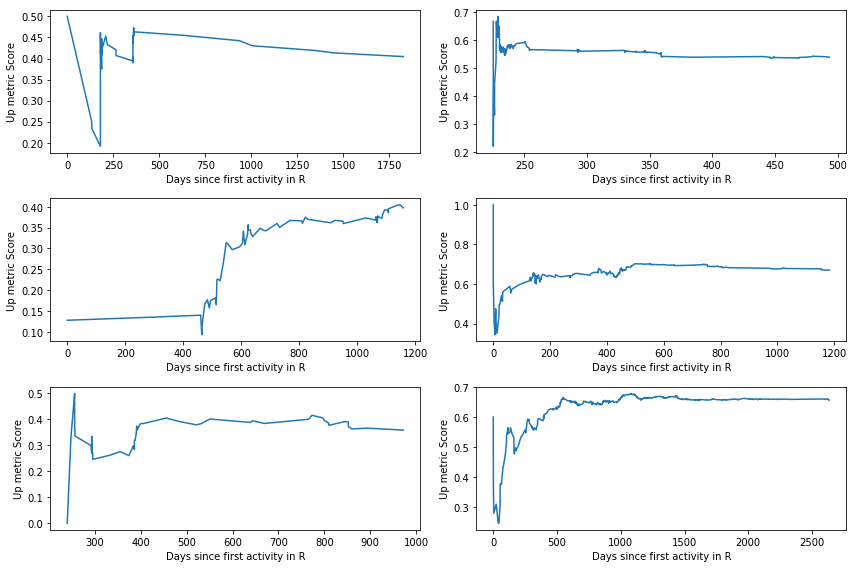

In [50]:
import random
r_users=summaryTableAnswer.loc[np.random.choice(summaryTableAnswer.index, 6)][" OwnerUserId"].tolist()
plt.figure(figsize=(12,8))

for i in range(0,6):
    user=r_users[i]
    plt.subplot(3,2,i+1)
    plt.xlabel("Days since first activity in R")
    plt.ylabel("Up metric Score")
    plt.plot(summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["DifferenceNumerator"].tolist(),summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["UpMetric"].tolist())
    plt.tight_layout()

plt.show()